In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as la
from scipy.stats import norm
from scipy.optimize import linprog

import warnings
from scipy.linalg import LinAlgWarning
from scipy.optimize import OptimizeWarning
warnings.filterwarnings(action='ignore', category=LinAlgWarning, module='scipy')
warnings.filterwarnings(action='ignore', category=OptimizeWarning, module='scipy')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='scipy') # overflow warnings in multiply in linprog

In [2]:
import os
import pickle
from datetime import datetime

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [4]:
from grid.policy import get_state, next_state, state_action_string, state_tuple
from grid.policy import get_policy, sample_policy, policy_noising, support, policy_data
from grid.policy import occupation_measure, occupation_measure_sanity
from grid.optimize import _sorted_risk_index as sorted_risk_index
from grid.optimize import _sorted_risk_dict as sorted_risk_dict
from grid.optimize import _min_risk as min_risk
from grid.optimize import _max_risk as max_risk
from grid.optimize import _pair_support as pair_support
from grid.params import _check_stochastic as check_stochastic
from grid.params import Rhigh, Rlow, Rbound
from grid.utils import sample_standard_simplex
from grid.plotting import plot_policy, plot_occupation_measure, plot_reward, plot_ratio

# Grid World

Consider an $m \times n$ board. Each tile of the board is a state. 

$$ \begin{array}{|c|c|c|}
\hline (0,0) & \cdots & (0,n-1) \\ \hline
\hline &  &  \\ \hline 
\hline (m-1,0) & \cdots & (m-1,n-1) \\
\hline
\end{array} $$

## Environment Parameters

In [5]:
m, n = 5, 5 # grid dimensions

In [8]:
actions = ['U','D','L','R','N']

In [9]:
states = [*range(m*n)]

In [10]:
delta = 0.05 # probability of moving randomly under each action

In [12]:
cost = 5.0 # cost of each cell (excluding obstacles)

In [11]:
epsilon = 0.01 # add Gaussian noise to reward and risk vectors 

In [13]:
discount = 0.95

In [14]:
final = get_state(m-1,n-1,m,n) # terminal state

In [15]:
init_state = get_state(0,0,m,n) # COMMENT OUT IF CHOSEN RANDOMLY
state_dist = np.eye(N=1,M=m*n,k=0).flatten() # COMMENT OUT IF CHOSEN RANDOMLY

In [19]:
T = 10*len(actions)*(m*n)**2 # time horizon, i.e., number of data points in dataset

## Obstacles

In [16]:
obstacle_num = 3

In [17]:
boundary = [i*n+j for i,j in zip([0]*n,list(range(n)))] + \
           [i*n+j for i,j in zip([m-1]*n,list(range(n)))] + \
           [i*n+j for i,j in zip(list(range(m)),[0]*m)] + \
           [i*n+j for i,j in zip(list(range(m)),[n-1]*m)]

boundary = [] # include boundary when choosing obstacles

In [18]:
# sample obstacles
states_excluded = list(set(states) - set([final,init_state]))
obstacles = []
while len(states_excluded)>0:
    obstacle = next_state(states_excluded)[0]
    states_excluded = list(set(states_excluded)-set([obstacle]))
    obstacles.append(obstacle)
    if len(obstacles)==obstacle_num:
        break        

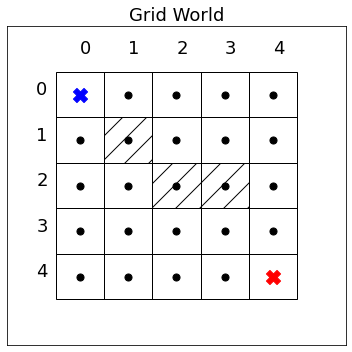

In [20]:
plot_policy({},states,actions,m,n,init_state,final,obstacles=obstacles,title='Grid World',title_fontsize=18, cell_unit_length=1.0)

In [6]:
tol = 1e-8 # tolerance for near 0 results

In [7]:
sensitivity = 1e-5 # sensitivity to improvement towards optimal value

## Actions

Actions are $\mathcal{A} = \{U,D,L,R,N\}$ correspond to moving *up*, *down*, *left*, *right*, or *none* for staying put. 

If possible, we move accordingly with probability $1-\delta$ under action $a=U,D,L,R$. There is a small transition probability $\delta$ to all other states.

For $a \in \mathcal{A}$, the transition matrix $P(a) \in {M}_{\vert \mathcal{S} \vert}(\mathbb{R})$ is
$$\begin{align*}
    & P(a)_{s',s} = \Pr[s' \vert s,a]
\end{align*}$$

i.e., the probability of transitioning from $s$ to $s'$ under action $a$. 

In [21]:
PU = delta/(m*n-1) * np.ones(shape=(m*n,m*n)) 

for i in range(m): # rows
    for j in range(n): # cols
        if i==0:
                PU[i*n+j,i*n+j] = 1 - delta            
        else:
                PU[(i-1)*n+j,i*n+j] = 1 - delta                    

In [22]:
PD = delta/(m*n-1)*np.ones(shape=(m*n,m*n)) 

for i in range(m): # rows
    for j in range(n): # cols
        if i==m-1:
            PD[i*n+j,i*n+j] = 1 - delta            
        else:
            PD[(i+1)*n+j,i*n+j] = 1 - delta                    

In [23]:
PL = delta/(m*n-1)*np.ones(shape=(m*n,m*n))

for i in range(m): # rows
    for j in range(n): # cols
        if j==0:
            PL[i*n+j,i*n+j] = 1 - delta            
        else:
            PL[i*n+(j-1),i*n+j] = 1 - delta                    

In [24]:
PR = delta/(m*n-1)*np.ones(shape=(m*n,m*n)) 

for i in range(m): # rows
    for j in range(n): # cols
        if j==n-1:
            PR[i*n+j,i*n+j] = 1 - delta            
        else:
            PR[i*n+(j+1),i*n+j] = 1 - delta                                        

In [25]:
deltaN = 0.5

PN = deltaN/(m*n-1)*np.ones(shape=(m*n,m*n))

for i in range(m): # rows
    for j in range(n): # cols
        PN[i*n+j,i*n+j] = 1 - deltaN

In [26]:
check_stochastic(PU)
check_stochastic(PD)
check_stochastic(PL)
check_stochastic(PR)
check_stochastic(PN)

## Reward

Consider $c \in \mathbb{R}^{\vert S \vert}$ and define the expected reward vector $r \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ to be

$$\begin{align*}
    & r(s,a) = \sum_{s' \in \mathcal{S}} c_{s'} P(a)_{s',s} 
\end{align*}$$

Pick some grid state $s_f$ as the final destination. Let $c_{s_f} = 0$ and $c_{s} = -1$ for $s \neq s_f$. Maximizing the reward would then imply reaching the destination by the shortest route. 

We can add a set of obstacles $\mathcal{S}_O \subseteq \mathcal{S}$ to the grid by setting $c_s = M \ll -1$ for $s \in \mathcal{S}_O$.

In __[Chow et al, NIPS '15](https://proceedings.neurips.cc/paper/2015/hash/64223ccf70bbb65a3a4aceac37e21016-Abstract.html)__ one has $M = {2}/{(1-\gamma)}$ for a discount factor $\gamma$.


In [27]:
M = 2/(1-discount) # obstacle penalty -1 

In [28]:
print('Obstacle penalty: {:.3f}'.format(M))

Obstacle penalty: 40.000


In [29]:
c = -cost*np.ones(m*n)[:,None] # negative cost

c[final] = 0.0
for o in obstacles:
    c[o] = -M

P = np.hstack([PU,PD,PL,PR,PN])
r = (c.T @ P).T # reward vector

We will add some jitter to the reward vector to ensure non-degeneracy.

In [30]:
r = r + norm(loc=0, scale=epsilon).rvs(r.shape)
r = np.where(r>0,0,r)

## Risk

We'll define a risk vector $d \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ weighed against moving along the upper or lower edges of the board (this will ensure no cell is degenerate).

We will also add a bit of additional risk for doing nothing.

There is a non-zero lower bound on risk to avoid "exploding" ratio for epsilon risks.

In [31]:
UR = Rbound*np.ones(m*n)[:,None]
DR = Rbound*np.ones(m*n)[:,None]
LR = Rbound*np.ones(m*n)[:,None]
RR = Rbound*np.ones(m*n)[:,None]
NR = Rlow*np.ones(m*n)[:,None]

for i in range(m):

    LR[n*i] = Rlow # walk into left boundary
    RR[n*i+(n-1)] = Rlow # walk into right boundary
    
for j in range(n):
    
    UR[j] = Rlow # walk into upper boundary
    DR[n*(m-1)+j] = Rlow # walk into lower boundary
        
    if j>0:
        LR[j] = Rhigh # walk along upper boundary
        LR[n*(m-1)+j] = Rhigh # walk along lower boundary
    
    if j<n-1:
        RR[j] = Rhigh # walk along upper boundary
        RR[n*(m-1)+j] = Rhigh # walk along lower boundary

In [32]:
d = np.vstack([UR,DR,LR,RR,NR]) # risk vector

We will add some jitter to the reward vector to ensure non-degeneracy.

In [33]:
d = d + norm(loc=0, scale=epsilon).rvs(d.shape)

d = -np.where(d<0,Rbound,d)

## Optimal Policy

The optimal policy for the EMRDP (with $\omega = 1$), phrased in terms of the occupancy measure $\rho^\pi \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ of $\pi$, is formulated in this case as

$$\min_{\pi} \bigg\{ \frac{r^T \rho^\pi}{d^T \rho^\pi} \,\bigg| \, Q\rho^\pi=\mu, \rho^\pi \geq 0 \bigg\} $$

In the discounted model, 
$$\begin{align*}
    Q = \bigg[ I-\gamma P(a_1) \, \bigg| \,\cdots\, \bigg|\, I - \gamma P(a_k) \bigg] , \quad
\end{align*}$$

for $\mathcal{A} = \{a_1,\ldots,a_k\}$, and $\mu$ is some initial state distribution.

In [34]:
I = np.identity(m*n)

Q = np.hstack([I-discount*PU,I-discount*PD,I-discount*PL,I-discount*PR,I-discount*PN])

The row vector $(1,\ldots,1) \in \mathbb{R}^{\vert \mathcal{S} \vert}$ is an eigenvector of $Q$ for the  eigenvalue $(1-\gamma)$.

In [35]:
np.ones((1,Q.shape[0])) @ Q / (1-discount)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## Run Optimization: Single Step

Run algorithm for finding the optimal policy manually, step by step.

In [36]:
is_eliminate = False # eliminate previously encountered (s,a)

In [37]:
state_num = len(states)
action_num = len(actions)

A = np.vstack([Q,d.T])
mu = state_dist

Initialize.

In [38]:
rhos, risks, rewards, switch_states, switch_actions = [], [], [], [], []

sas = np.ones(state_num*action_num)
sorted_risk_ind = sorted_risk_index(d,state_num,action_num,sas)

min_rho = min_risk(Q,state_dist,discount,d,tol/100) # decrease numerical sensitivity for min

rhos = [min_rho]
risks = [(d.T@rhos[-1])[0]]
rewards = [(r.T@rhos[-1])[0]]
switch_states = [None]
switch_actions = [None]

stop = False

Running the next cell repeatedly, will manually produce the next policy on the Pareto front.

In [74]:
rho, risk, reward = rhos[-1], risks[-1], rewards[-1]

supp = support(rho)

assert supp.sum() == len(states), \
'Support of deterministic policy must be = size of state-action space. \
This is likely due to numerical sensitivity.'

if not is_eliminate: # re-esbalish original state-action space
    sas = np.ones(state_num*action_num)

sas = sas*(~supp) # sas*(~support_adjust(supp,sorted_risk_ind,state_num,action_num))

state_actions = sorted_risk_dict(sorted_risk_ind, states, actions, sas)

candidates = {'states': [], 'actions': [], 'rhos': [], 'risks': [], 'rewards': []}

if not stop:

    for s in states:

        for a in state_actions[s]:

            I = supp + pair_support(s,a,states,actions)
            AIinv = la.inv(A[:,I])
            B = (r.T[:,I]@AIinv)@A - r.T
            B[np.isclose(B,0.0,atol=tol)] = 0.0

            if np.all(B >= 0.0):                        

                J = np.array([*range(A.shape[-1])])[(~(B > 0)).flatten()] # I
                AJinv = la.inv(A[:,J])

                atol = abs(int(np.log10(tol)))
                # convert to longdouble to avoid numpy overflow warnings in multiply
                AJinv = np.array(AJinv, dtype=np.longdouble)
                mu = np.array(mu, dtype=np.longdouble)
                lb = np.longdouble(risks[0])
                tol = np.longdouble(tol)

                c = np.zeros(AJinv.shape[0])
                c[-1] = 1.0
                coeff = -1.0 # linprog minimizes

                res = linprog(
                    coeff*c,
                    A_ub = -AJinv, b_ub = np.zeros(AJinv.shape[0]), 
                    A_eq = np.identity(AJinv.shape[0])[:-1,], b_eq = (1-discount)*mu, 
                    bounds = (lb,None),
                    options = {'cholesky': False, 'sym_pos': False, 'tol': tol/100, 'lstsq': True, 'presolve': True}
                )

                next_risk = np.around(res['x'][-1],atol)

                next_rhoI = AJinv@np.hstack([(1-discount)*mu,np.array([next_risk])])[:,None]
                next_rhoI = np.where(np.isclose(next_rhoI,0.0,atol=tol),0.0,next_rhoI).flatten()
                next_rhoI = np.where(next_rhoI<0,0.0,next_rhoI)
                next_rho = np.zeros(A.shape[-1])
                next_rho[I] = next_rhoI
                next_reward = (next_rho@r)[0]

                candidates['states'].append(s)
                candidates['actions'].append(a)
                candidates['rhos'].append(next_rho)
                candidates['risks'].append(next_risk)
                candidates['rewards'].append(next_reward)

    if candidates['risks']:

        if (len(risks)>1) and (len(candidates['risks'])==1):

            stop = True

            print('The End')

        else:

            risk_max_idx = np.array(candidates['risks']).argmax()
            next_rho = candidates['rhos'][risk_max_idx]
            next_risk = candidates['risks'][risk_max_idx]
            next_reward = candidates['rewards'][risk_max_idx]
            s = candidates['states'][risk_max_idx]
            a = candidates['actions'][risk_max_idx]

            print(f'---------------------------------------------------------\nSwitch to action {a} at cell {state_tuple(s,m,n)}')
            print('Next reward: {:.3f}, Next risk: {:.3f}, Next ratio: {:.3f}\n---------------------------------------------------------'.format(next_reward,next_risk,next_reward/next_risk))

            rhos.append(next_rho)
            risks.append(next_risk)
            rewards.append(next_reward)
            switch_states.append(s)
            switch_actions.append(a)

    else:

        print('NeighborFail')


---------------------------------------------------------
Switch to action D at cell (2, 3)
Next reward: -2.167, Next risk: -6.093, Next ratio: 0.356
---------------------------------------------------------


/Users/oritd/.pyenv/versions/3.8.0/envs/emrdp/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:311: RuntimeWarning: overflow encountered in multiply
  d_x = u + p * d_tau
/Users/oritd/.pyenv/versions/3.8.0/envs/emrdp/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:425: RuntimeWarning: invalid value encountered in multiply
  x = x + alpha * d_x
/Users/oritd/.pyenv/versions/3.8.0/envs/emrdp/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:427: RuntimeWarning: invalid value encountered in multiply
  z = z + alpha * d_z


In [75]:
# sanity check: all rhos are occupation measures

for i,rho in enumerate(rhos):
    occupation_measure_sanity(rho,A,state_dist,discount,report={},tol=tol*100)

## Results

Plot algorithm results for finding the true optimal policy.

In [76]:
for i, (re, ri) in enumerate(zip(rewards, risks)):
    print('Iteration {}: reward {:.3f}, risk {:.3f}, ratio: {:.3f}'.format(i,(re),ri,(re)/(ri)))

Iteration 0: reward -7.462, risk -10.009, ratio: 0.745
Iteration 1: reward -7.312, risk -10.009, ratio: 0.731
Iteration 2: reward -7.259, risk -10.009, ratio: 0.725
Iteration 3: reward -7.147, risk -10.009, ratio: 0.714
Iteration 4: reward -7.022, risk -10.009, ratio: 0.702
Iteration 5: reward -6.897, risk -10.009, ratio: 0.689
Iteration 6: reward -5.275, risk -10.007, ratio: 0.527
Iteration 7: reward -5.096, risk -10.005, ratio: 0.509
Iteration 8: reward -5.019, risk -10.004, ratio: 0.502
Iteration 9: reward -4.950, risk -10.003, ratio: 0.495
Iteration 10: reward -4.918, risk -10.003, ratio: 0.492
Iteration 11: reward -4.173, risk -9.993, ratio: 0.418
Iteration 12: reward -4.128, risk -9.993, ratio: 0.413
Iteration 13: reward -4.088, risk -9.992, ratio: 0.409
Iteration 14: reward -4.052, risk -9.992, ratio: 0.405
Iteration 15: reward -3.975, risk -9.991, ratio: 0.398
Iteration 16: reward -3.919, risk -9.990, ratio: 0.392
Iteration 17: reward -3.788, risk -9.988, ratio: 0.379
Iteration

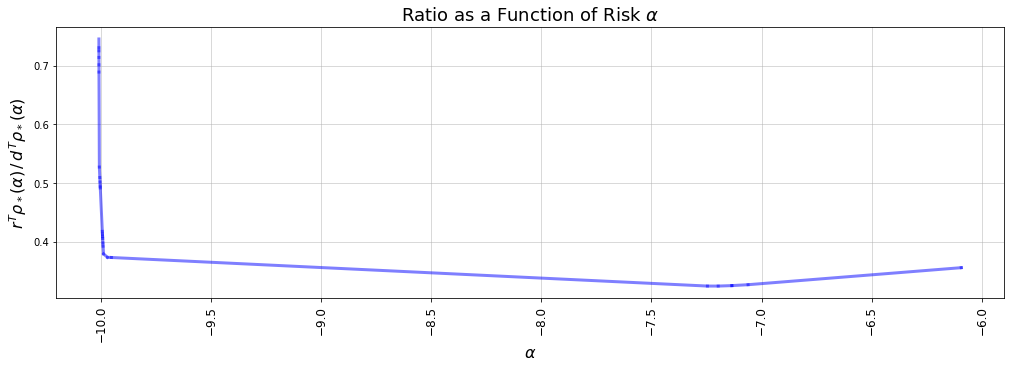

In [77]:
if len(rewards)>1:
    plot_ratio(risks, rewards, atol=2, set_ticks=False, figsize=(17,5))

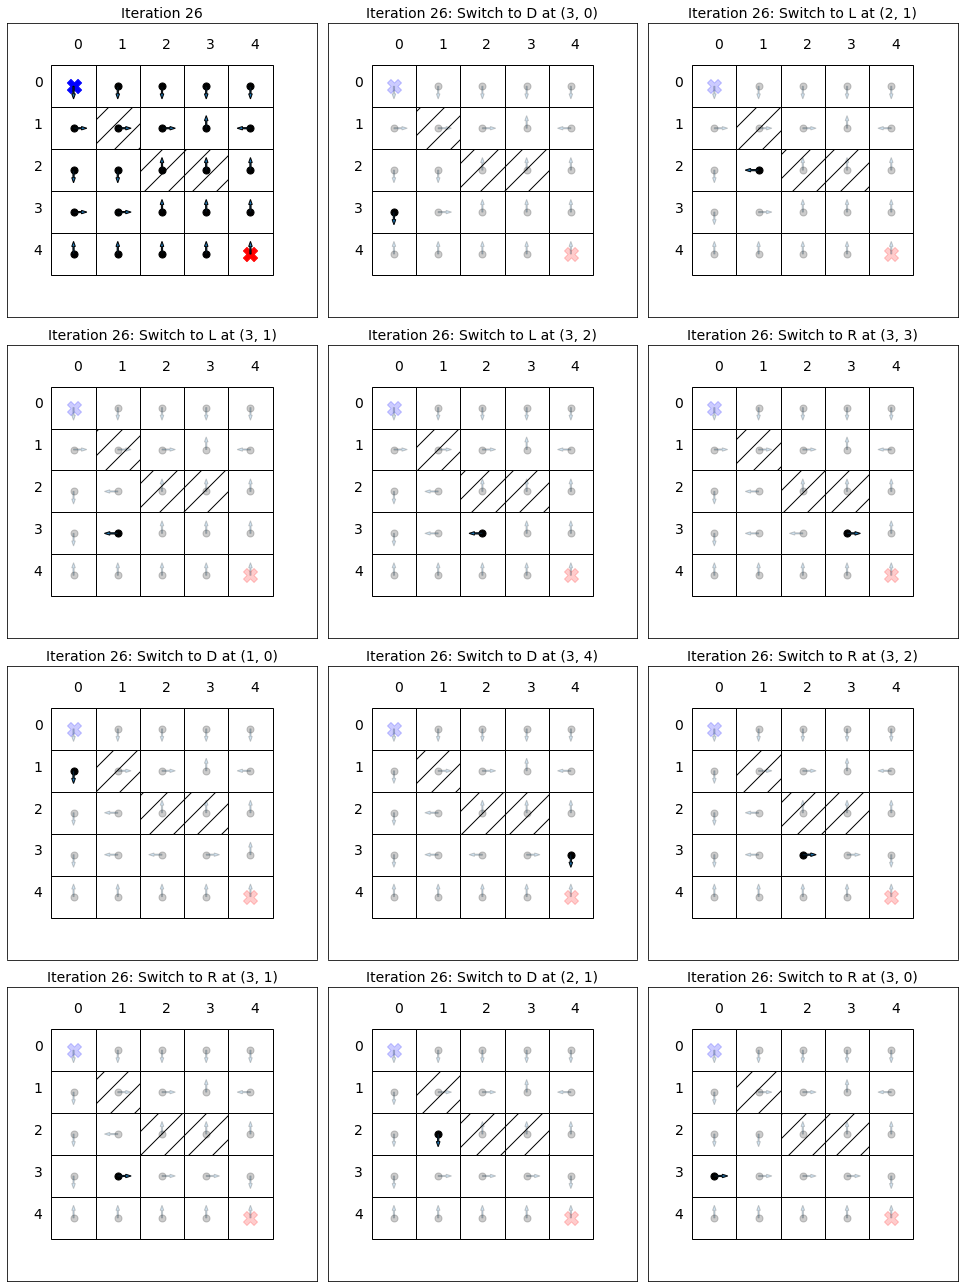

In [78]:
N = 12
policies = [get_policy(np.around(rho,4), states, actions) for rho in rhos[:N]]
titles = []
for s,a in zip(switch_states,switch_actions):
    if s is not None and a is not None:
        title = f'Iteration {i}: Switch to {a} at {state_tuple(s,m,n)}'
    else:
        title = f'Iteration {i}'
    titles.append(title)
    
plot_policy(policies,states,actions,m,n,init_state,final,obstacles=obstacles,
            switch_state=switch_states,switch_action=switch_actions,title=titles,cell_unit_length=0.9,ncols=3)

## Run Optimization: End to End

In [44]:
from grid.optimize import optimal_policy

In [45]:
fun_rhos, fun_rewards, fun_risks, fun_success = \
    optimal_policy(
        states,actions,Q,r,d,state_dist,discount,sensitivity=sensitivity,tol=tol,is_verbose=False
)

In [46]:
print(f'Theoretical optimum found with confidence: {fun_success}')

Theoretical optimum found with confidence: True


In [47]:
argmin=0

for i, (re, ri) in enumerate(zip(fun_rewards, fun_risks)):
    # print('Iteration {}: reward {:.3f}, risk {:.3f}, ratio: {:.3f}'.format(i,(re),ri,(re)/(ri)))
    argmin = i if (re)/(ri) < fun_rewards[argmin]/fun_risks[argmin] else argmin

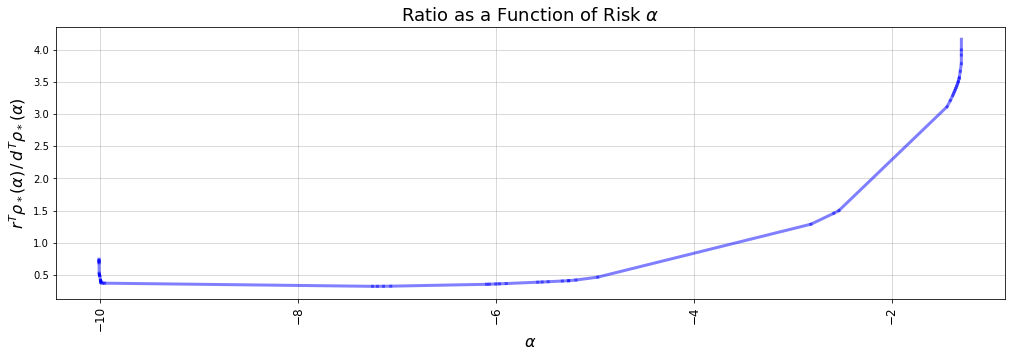

In [48]:
# plot pareto for ratio
plot_ratio(fun_risks, fun_rewards, atol=2, set_ticks=False, figsize=(17,5))

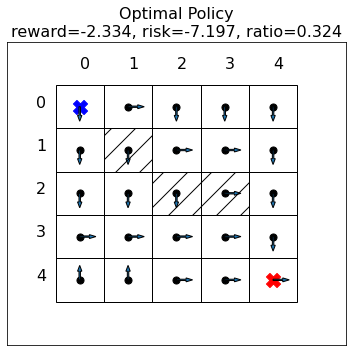

In [79]:
fun_p = get_policy(np.around(fun_rhos[argmin],4), states, actions)

title = 'Optimal Policy\nreward={:.3f}, risk={:.3f}, ratio={:.3f}'.format(fun_rewards[argmin],fun_risks[argmin],fun_rewards[argmin]/fun_risks[argmin])
plot_policy(fun_p,states,actions,m,n,init_state,final,obstacles=obstacles,cell_unit_length=1.0,title=title,title_fontsize=16)